In [4]:
%load_ext autoreload
%autoreload 2

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Plotting helper functions

In [889]:
def plot_miscoverage_examples(test_dataset, coverages, intervals):
    miscovered_idx = torch.nonzero(~coverages, as_tuple=False)[:, 0].tolist()
    fig, axs = plt.subplots(5, 2, figsize=(10, 10), sharey=True)

    for ax in axs.flat:
        i = np.random.choice(miscovered_idx)
        ax.fill_between(range(test_dataset[i][1].size(0)),
                         intervals[i, 0].flatten().tolist(), 
                         intervals[i, 1].flatten().tolist(), 
                         color="r", alpha=0.25)
        ax.plot(intervals[i, 0].flatten().tolist(), linestyle="--", color="r")
        ax.plot(intervals[i, 1].flatten().tolist(), linestyle="--", color="r")
        ax.plot((intervals[i, 0] + (intervals[i, 1] - intervals[i, 0]) / 2).flatten().tolist(), linestyle="--", linewidth=3, color="r")

        ax.scatter(range(test_dataset[i][1].size(0)), test_dataset[i][1].flatten().tolist(), color="black")

        ax.set(xlabel='Time step', ylabel='Prediction')
    plt.show()
    
def plot_ts(dataset, coverages, intervals, idx=None, forecast_only=False):
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 8), sharex=True)
    
    if idx is None:
        idx = range(len(dataset))

    for ax in axs.flat:
        i = np.random.choice(idx)
        
        # Derive unpadded sequences and targets
        sequence, target, length = dataset[i]
        
        horizon = min(len(target), length)
        sequence, target = sequence[:length].flatten().tolist(), target[:horizon].flatten().tolist()
        
        if not forecast_only:
            # (Scatter)plot of the time series
            ax.plot(range(1, length+1), sequence, color="black")
            
            # Prediction start vertical
            ax.axvline(length, linestyle="--", color="black")
        
        ax.scatter(range(length + 1, length + horizon + 1), target, color="black")
        
        # Interval boundaries
        lower = [sequence[-1]] + intervals[i, 0].flatten().tolist()[:horizon]
        upper = [sequence[-1]] + intervals[i, 1].flatten().tolist()[:horizon]
        pred = [sequence[-1]] + (intervals[i, 0] + (intervals[i, 1] - intervals[i, 0]) / 2).flatten().tolist()[:horizon]
        
        ax.fill_between(range(length, length + horizon + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + horizon + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), upper, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), pred, linestyle="--", linewidth=3, color="r")

        ax.set(ylabel='Prediction')
    
    plt.xlabel('Time step')
    #     plt.ylabel('Prediction')
    plt.show()

## Hyperparameters

In [963]:
# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = [0.1 * k for k in range(seq_len + horizon)]
periodicity = 2
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

## Generate datasets

In [964]:
from utils.make_data import generate_autoregressive_forecast_dataset
train_dataset = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
calibration_dataset = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
test_dataset = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)

## Conformal forecaster

In [965]:
from models.conformal import ConformalForecaster
model = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)

In [966]:
model.fit(train_dataset, calibration_dataset, epochs=epochs, lr=lr, batch_size=batch_size)

Epoch: 0	Train loss: 90.03600997924805
Epoch: 50	Train loss: 16.06012830734253
Epoch: 100	Train loss: 13.419668865203857
Epoch: 150	Train loss: 12.036290264129638
Epoch: 200	Train loss: 10.706856536865235
Epoch: 250	Train loss: 9.539083862304688
Epoch: 300	Train loss: 8.627713441848755
Epoch: 350	Train loss: 8.575873565673827
Epoch: 400	Train loss: 8.18711452484131
Epoch: 450	Train loss: 7.170155477523804
Epoch: 500	Train loss: 7.597601652145386
Epoch: 550	Train loss: 8.1293475151062
Epoch: 600	Train loss: 6.668988990783691
Epoch: 650	Train loss: 6.817715740203857
Epoch: 700	Train loss: 6.375599479675293
Epoch: 750	Train loss: 6.400059652328491
Epoch: 800	Train loss: 6.817319059371949
Epoch: 850	Train loss: 7.949629306793213
Epoch: 900	Train loss: 6.128638410568238
Epoch: 950	Train loss: 6.272935771942139


## Coverage evaluation

In [967]:
coverages, intervals = model.evaluate_coverage(test_dataset)
print('% of series within predicted intervals: {}'.format(torch.mean(coverages.float(), dim=0).item()))

% of series within predicted intervals: 0.9200000166893005


## Plotting

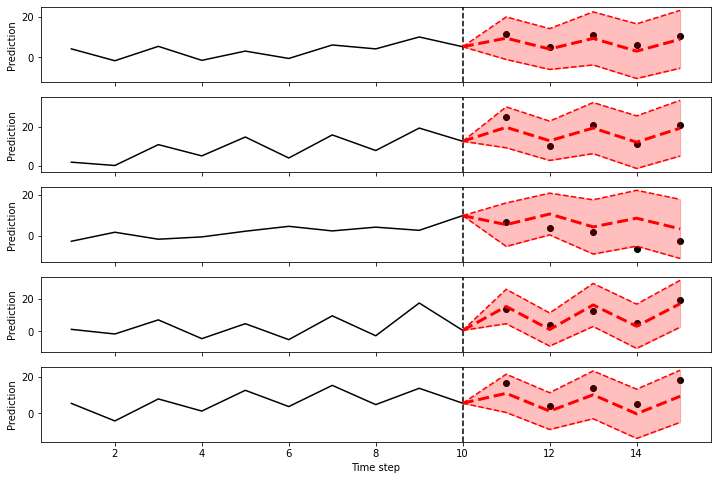

In [968]:
plot_ts(test_dataset, coverages, intervals)

Interval widths:

In [977]:
(intervals[:, 1] - intervals[:, 0]).squeeze().mean(dim=0).tolist()

[21.165647506713867,
 20.323575973510742,
 26.415739059448242,
 27.204988479614258,
 28.79669761657715]

In [976]:
(intervals[:, 1] - intervals[:, 0]).squeeze().mean()

tensor(24.7813, grad_fn=<MeanBackward0>)

In comparison with BJ-RNN on the same dataset and parameters (with the underlying RNN achieving the same training loss), Conformal forecaster:
* was significantly, incomparatively faster
* while it has lower empirical coverage (92% vs 100%) it is still at the sufficient level satisfying the theoretical guarantees
* has much smaller interval widths (24.7813 vs 231.94795306396472)


## Collecting all data

Things to try:
1. increasing (time-dependent) noise variance, no periodicity: try visibly increasing series
2. noise sweep (*will probably require normalisation* for good performance but should still show guarantees although with wide intervals for the wide examples)
3. periodic patterns
4. different time series lengths

In [978]:
from utils.train_conformal import train_conformal_forecaster

In [ ]:
results = []
for i in range(1, 6):
    noise_profile = [0.1 * k * i for k in range(seq_len + horizon)]
    result = train_conformal_forecaster(noise_profile=noise_profile)
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results.append(result)

In [983]:
from utils.make_data import generate_autoregressive_forecast_dataset

train_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
calibration_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
test_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)

## Conformal forecaster

In [984]:
from models.conformal import ConformalForecaster
model_x = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)

In [985]:
model_x.fit(train_dataset_x, calibration_dataset_x, epochs=epochs, lr=lr, batch_size=batch_size)

Epoch: 0	Train loss: 96.71368026733398
Epoch: 50	Train loss: 16.560448932647706
Epoch: 100	Train loss: 14.431479930877686
Epoch: 150	Train loss: 12.659294700622558
Epoch: 200	Train loss: 12.42998971939087
Epoch: 250	Train loss: 10.524146461486817
Epoch: 300	Train loss: 9.547363376617431
Epoch: 350	Train loss: 9.923514461517334
Epoch: 400	Train loss: 9.386300659179687
Epoch: 450	Train loss: 9.263593387603759
Epoch: 500	Train loss: 8.214104843139648
Epoch: 550	Train loss: 7.847737741470337
Epoch: 600	Train loss: 7.737237644195557
Epoch: 650	Train loss: 7.695864248275757
Epoch: 700	Train loss: 7.722361993789673
Epoch: 750	Train loss: 7.293479585647583
Epoch: 800	Train loss: 7.3325395584106445
Epoch: 850	Train loss: 6.865914535522461
Epoch: 900	Train loss: 6.8702412128448485
Epoch: 950	Train loss: 9.24401330947876


In [986]:
# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = None
periodicity = 2
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

results = []
for i in range(1, 6):
    noise_profile = [0.1 * k * i for k in range(seq_len + horizon)]
    train_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
    calibration_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    test_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    model_x = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)
    
    model_x.fit(train_dataset_x, calibration_dataset_x, epochs=epochs, lr=lr, batch_size=batch_size)
    
    coverages, intervals = model_x.evaluate_coverage(test_dataset_x)
    mean_coverage = torch.mean(coverages.float(), dim=0).item()
    interval_widths = (intervals[:, 1] - intervals[:, 0]).squeeze().mean(
        dim=0).tolist()

    result = {'coverages': coverages,
               'intervals': intervals,
               'mean_coverage': mean_coverage,
               'interval_widths': interval_widths}
    
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results.append(result)
    

Epoch: 0	Train loss: 93.6583969116211
Epoch: 50	Train loss: 16.307931995391847
Epoch: 100	Train loss: 14.921547126770019
Epoch: 150	Train loss: 13.85702428817749
Epoch: 200	Train loss: 12.792230319976806
Epoch: 250	Train loss: 11.747208213806152
Epoch: 300	Train loss: 10.877283763885497
Epoch: 350	Train loss: 10.84754819869995
Epoch: 400	Train loss: 9.792602157592773
Epoch: 450	Train loss: 9.538048362731933
Epoch: 500	Train loss: 9.103987741470338
Epoch: 550	Train loss: 8.536530685424804
Epoch: 600	Train loss: 8.183154964447022
Epoch: 650	Train loss: 7.824663877487183
Epoch: 700	Train loss: 8.21445279121399
Epoch: 750	Train loss: 7.824004602432251
Epoch: 800	Train loss: 7.423264789581299
Epoch: 850	Train loss: 9.015694332122802
Epoch: 900	Train loss: 7.0830858707427975
Epoch: 950	Train loss: 7.266385555267334
Model 1:	coverage: 0.9259999990463257	widths: [19.406827926635742, 18.344846725463867, 25.127168655395508, 23.551210403442383, 30.696773529052734]
Epoch: 0	Train loss: 97.99895095

In [991]:
# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = None
periodicity = 2
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=4000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

# results_4000 = []
for i in range(5, 6):
    noise_profile = [0.1 * k * i for k in range(seq_len + horizon)]
    train_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
    calibration_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    test_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    model_x = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)
    
    model_x.fit(train_dataset_x, calibration_dataset_x, epochs=epochs, lr=lr, batch_size=batch_size)
    
    coverages, intervals = model_x.evaluate_coverage(test_dataset_x)
    mean_coverage = torch.mean(coverages.float(), dim=0).item()
    interval_widths = (intervals[:, 1] - intervals[:, 0]).squeeze().mean(
        dim=0).tolist()

    result = {'coverages': coverages,
               'intervals': intervals,
               'mean_coverage': mean_coverage,
               'interval_widths': interval_widths}
    
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results_4000.append(result)
    

Epoch: 0	Train loss: 131.66316909790038
Epoch: 50	Train loss: 57.15425033569336
Epoch: 100	Train loss: 53.97360000610352
Epoch: 150	Train loss: 50.63601493835449
Epoch: 200	Train loss: 46.72647476196289
Epoch: 250	Train loss: 43.096554565429685
Epoch: 300	Train loss: 39.958683013916016
Epoch: 350	Train loss: 39.79352645874023
Epoch: 400	Train loss: 36.788832092285155
Epoch: 450	Train loss: 36.722150039672854
Epoch: 500	Train loss: 35.21601257324219
Epoch: 550	Train loss: 35.63125381469727
Epoch: 600	Train loss: 34.07886371612549
Epoch: 650	Train loss: 32.697760009765624
Epoch: 700	Train loss: 32.290945816040036
Epoch: 750	Train loss: 35.08457450866699
Epoch: 800	Train loss: 34.27659873962402
Epoch: 850	Train loss: 30.97606506347656
Epoch: 900	Train loss: 30.8461051940918
Epoch: 950	Train loss: 32.64703636169433
Epoch: 1000	Train loss: 31.458338737487793
Epoch: 1050	Train loss: 34.405197334289554
Epoch: 1100	Train loss: 29.644252967834472
Epoch: 1150	Train loss: 29.563762664794922
Epoch

In [994]:
for result in results_4000:
    print(result['mean_coverage'])

0.9160000085830688
0.9340000152587891
0.9359999895095825
0.9139999747276306
0.9319999814033508


In [995]:
import pickle

In [996]:
with open('results_4000_epochs_increasing_time_dependent_noise.pkl', 'wb') as output:
    pickle.dump(results_4000, output, pickle.HIGHEST_PROTOCOL)

In [997]:
len(results)

5

In [998]:
with open('results_1000_epochs_increasing_time_dependent_noise.pkl', 'wb') as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

In [999]:
for result in results:
    print(result['mean_coverage'])

0.9259999990463257
0.9200000166893005
0.9319999814033508
0.8740000128746033
0.8600000143051147


## Static noise, no periodic component

In [1156]:
from models.conformal import ConformalForecaster
from utils.make_data import generate_autoregressive_forecast_dataset, seasonal

# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = None
periodicity = None
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

results_static_noise_no_periodic = []
for i in range(1, 6):
    noise_profile = [0.1 * i for k in range(seq_len + horizon)]
    train_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
    calibration_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    test_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    model_x = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)
    
    model_x.fit(train_dataset_x, calibration_dataset_x, epochs=epochs, lr=lr, batch_size=batch_size)
    
    coverages, intervals = model_x.evaluate_coverage(test_dataset_x)
    mean_coverage = torch.mean(coverages.float(), dim=0).item()
    interval_widths = (intervals[:, 1] - intervals[:, 0]).squeeze().mean(
        dim=0).tolist()

    result = {'coverages': coverages,
               'intervals': intervals,
               'mean_coverage': mean_coverage,
               'interval_widths': interval_widths}
    
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results_static_noise_no_periodic.append(result)

Epoch: 0	Train loss: 64.73751258850098
Epoch: 50	Train loss: 8.669367742538451
Epoch: 100	Train loss: 7.623492670059204
Epoch: 150	Train loss: 6.645146799087525
Epoch: 200	Train loss: 5.896826124191284
Epoch: 250	Train loss: 5.735523414611817
Epoch: 300	Train loss: 4.973992538452149
Epoch: 350	Train loss: 4.7342794179916385
Epoch: 400	Train loss: 4.575479412078858
Epoch: 450	Train loss: 5.338227844238281
Epoch: 500	Train loss: 4.2226245403289795
Epoch: 550	Train loss: 4.114314460754395
Epoch: 600	Train loss: 4.385229587554932
Epoch: 650	Train loss: 4.022645592689514
Epoch: 700	Train loss: 3.6495891571044923
Epoch: 750	Train loss: 6.890333604812622
Epoch: 800	Train loss: 3.94029016494751
Epoch: 850	Train loss: 5.4021093368530275
Epoch: 900	Train loss: 3.867035174369812
Epoch: 950	Train loss: 4.005012631416321
Model 1:	coverage: 0.9359999895095825	widths: [11.162919044494629, 15.334916114807129, 17.547517776489258, 19.968019485473633, 22.069976806640625]
Epoch: 0	Train loss: 66.028310394

In [1013]:
with open('results_1000_epochs_results_static_noise_no_periodic.pkl', 'wb') as output:
    pickle.dump(results_static_noise_no_periodic, output, pickle.HIGHEST_PROTOCOL)

In [1023]:
with open('results_1000_epochs_results_static_noise_no_periodic.pkl', 'rb') as f:
    results_static_noise_no_periodic = pickle.load(f)

## Time-dependent noise, no periodic component

In [ ]:
from utils.make_data import generate_autoregressive_forecast_dataset
from utils.train_conformal import train_conformal_forecaster

results_time_dependent_noise_no_periodic = []
for i in range(1, 6):
    noise_profile = [0.1 * k * i for k in range(seq_len + horizon)]
    result = train_conformal_forecaster(noise_profile=noise_profile)
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results_time_dependent_noise_no_periodic.append(result)

In [1166]:
from models.conformal import ConformalForecaster
from utils.make_data import generate_autoregressive_forecast_dataset, seasonal

# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = None
periodicity = None
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

results_time_dependent_noise_no_periodic = []
models = []
test_datasets = []
for i in range(1, 6):
    noise_profile = [0.1 * i * k for k in range(seq_len + horizon)]
    train_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
    calibration_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    test_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    model_x = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)
    
    model_x.fit(train_dataset_x, calibration_dataset_x, epochs=epochs, lr=lr, batch_size=batch_size)
    
    coverages, intervals = model_x.evaluate_coverage(test_dataset_x)
    mean_coverage = torch.mean(coverages.float(), dim=0).item()
    interval_widths = (intervals[:, 1] - intervals[:, 0]).squeeze().mean(
        dim=0).tolist()

    result = {'coverages': coverages,
               'intervals': intervals,
               'mean_coverage': mean_coverage,
               'interval_widths': interval_widths}
    
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results_time_dependent_noise_no_periodic.append(result)
    
    models.append(model_x)
    test_datasets.append(test_dataset_x)

Epoch: 0	Train loss: 72.79970054626465
Epoch: 50	Train loss: 10.753300666809082
Epoch: 100	Train loss: 9.665511417388917
Epoch: 150	Train loss: 8.68122067451477
Epoch: 200	Train loss: 7.215913248062134
Epoch: 250	Train loss: 6.424487113952637
Epoch: 300	Train loss: 6.276694822311401
Epoch: 350	Train loss: 6.728419017791748
Epoch: 400	Train loss: 6.094639635086059
Epoch: 450	Train loss: 6.835986518859864
Epoch: 500	Train loss: 5.779018115997315
Epoch: 550	Train loss: 5.127368450164795
Epoch: 600	Train loss: 5.106873416900635
Epoch: 650	Train loss: 4.682569885253907
Epoch: 700	Train loss: 4.492441177368164
Epoch: 750	Train loss: 4.52684383392334
Epoch: 800	Train loss: 4.5125319480896
Epoch: 850	Train loss: 4.5281579971313475
Epoch: 900	Train loss: 4.2523935556411745
Epoch: 950	Train loss: 4.550999498367309
Model 1:	coverage: 0.8960000276565552	widths: [13.914549827575684, 17.362184524536133, 19.962055206298828, 22.372737884521484, 23.328960418701172]
Epoch: 0	Train loss: 75.1327224731445

In [1022]:
with open('results_1000_epochs_results_time_dependent_noise_no_periodic.pkl', 'wb') as output:
    pickle.dump(results_time_dynamic_noise_no_periodic, output, pickle.HIGHEST_PROTOCOL)

In [1027]:
with open('results_1000_epochs_results_time_dependent_noise_no_periodic.pkl', 'rb') as f:
    results_time_dynamic_noise_no_periodic = pickle.load(f)

In [1164]:
for result in results_time_dependent_noise_no_periodic:
    print(result['mean_coverage'])

0.9319999814033508
0.9139999747276306
0.921999990940094
0.9259999990463257
0.8880000114440918


In [1165]:
for result in results_time_dependent_noise_no_periodic:
    print(np.mean(result['interval_widths']), np.std(result['interval_widths']))

19.926713371276854 3.9321119315626922
22.02841911315918 3.53017599369445
29.807537078857422 5.230106572023895
32.13668022155762 4.824160229317419
39.38756484985352 5.554523703003826


In [1159]:
for result in results_static_noise_no_periodic:
    print(result['mean_coverage'])

0.9359999895095825
0.9319999814033508
0.9359999895095825
0.9259999990463257
0.9380000233650208


In [1160]:
for result in results_static_noise_no_periodic:
    print(np.mean(result['interval_widths']), np.std(result['interval_widths']))

17.216669845581055 3.779493868695349
17.367822265625 3.969926370610744
18.36235065460205 3.756618162535405
18.15559253692627 4.145801647835989
18.121648597717286 4.129881528342482


In [1033]:
np.mean([29.70712175, 32.2419688,  36.25516169, 35.82950735, 35.10840432]), np.std([29.70712175, 32.2419688,  36.25516169, 35.82950735, 35.10840432])

(33.828432782, 2.491333472113982)

In [1147]:
def plot_compare(datasets, coverages, intervals, idx=None, forecast_only=False, figure_name=None, figsize=(30, 4)):
    fig, axs = plt.subplots(nrows=1, ncols=len(datasets), figsize=figsize, sharey=True)
    
    if idx is None:
        idx = range(len(datasets[0]))
    
    
    
    for j, ax in enumerate(axs.flat):
        i = np.random.choice(idx)
        dataset = datasets[j]
        
        if j == 0:
            ax.set(ylabel='Prediction')
        
        # Derive unpadded sequences and targets
        sequence, target, length = dataset[i]
        
        interval = intervals[j]
        
        horizon = min(len(target), length)
        sequence, target = sequence[:length].flatten().tolist(), target[:horizon].flatten().tolist()
        
        if not forecast_only:
            # (Scatter)plot of the time series
            ax.plot(range(1, length+1), sequence, color="black")
            
            # Prediction start vertical
            ax.axvline(length, linestyle="--", color="black")
        
        ax.scatter(range(length + 1, length + horizon + 1), target, color="black")
        
        # Interval boundaries
        lower = [sequence[-1]] + interval[i, 0].flatten().tolist()[:horizon]
        upper = [sequence[-1]] + interval[i, 1].flatten().tolist()[:horizon]
        pred = [sequence[-1]] + (interval[i, 0] + (interval[i, 1] - interval[i, 0]) / 2).flatten().tolist()[:horizon]
        
        ax.fill_between(range(length, length + horizon + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + horizon + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), upper, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), pred, linestyle="--", linewidth=3, color="r")

#         ax.set(ylabel='Prediction')
        ax.set(xlabel='Time step')
#         ax.set_title('$\sigma_t^2$={:.1f}$t$'.format(0.1 * (j+1)))
    
#     plt.xlabel('Time step')
#     plt.ylabel('Prediction')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    figure_name = 'figure' if None else figure_name
    plt.savefig('{}.png'.format(figure_name) , bbox_inches='tight')
    plt.show()

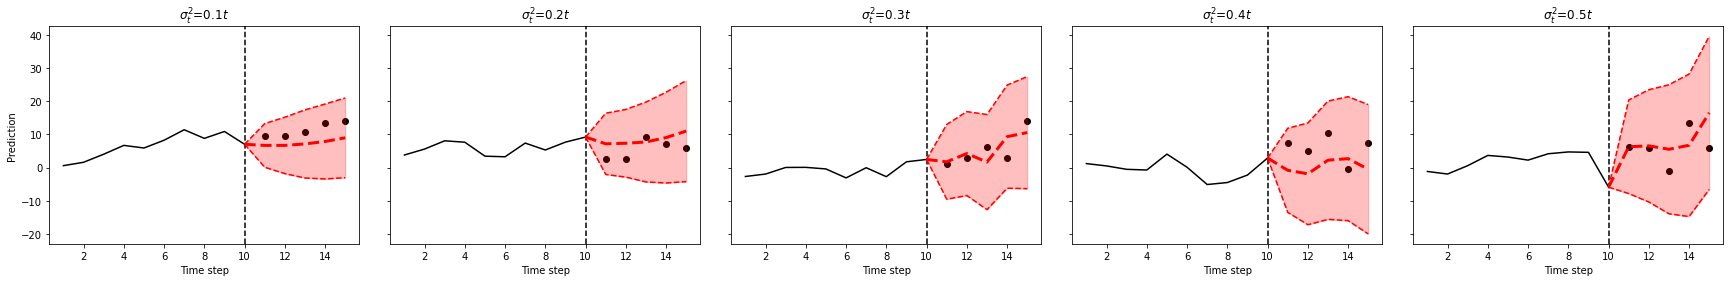

In [1137]:
plot_compare(test_datasets, all_coverages, all_intervals)


In [1049]:
all_coverages = [result['coverages'] for result in results_time_dependent_noise_no_periodic]
all_intervals = [result['intervals'] for result in results_time_dependent_noise_no_periodic]

## Periodic component, longer time series

In [1138]:
from models.conformal import ConformalForecaster
from utils.make_data import generate_autoregressive_forecast_dataset, seasonal

# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 40
horizon = 10
noise_profile = None
periodicity = None
amplitude = 5
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

results_varying_periodicity = {}
models_varying_periodicity = []
test_datasets_varying_periodicity = []
for i in [2, 10]:
    periodicity = i
    noise_profile = [0.1 * k for k in range(seq_len + horizon)]
    train_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
    calibration_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    test_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    model_x = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)
    
    model_x.fit(train_dataset_x, calibration_dataset_x, epochs=epochs, lr=lr, batch_size=batch_size)
    
    coverages, intervals = model_x.evaluate_coverage(test_dataset_x)
    mean_coverage = torch.mean(coverages.float(), dim=0).item()
    interval_widths = (intervals[:, 1] - intervals[:, 0]).squeeze().mean(
        dim=0).tolist()

    result = {'coverages': coverages,
               'intervals': intervals,
               'mean_coverage': mean_coverage,
               'interval_widths': interval_widths}
    
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results_varying_periodicity['periodicity={}'.format(i)] = result
    
    models_varying_periodicity.append(model_x)
    test_datasets_varying_periodicity.append(test_dataset_x)

Epoch: 0	Train loss: 2785.1212646484373
Epoch: 50	Train loss: 793.8268737792969
Epoch: 100	Train loss: 418.68806915283204
Epoch: 150	Train loss: 304.95550231933595
Epoch: 200	Train loss: 256.57142639160156
Epoch: 250	Train loss: 231.62604675292968
Epoch: 300	Train loss: 217.0735595703125
Epoch: 350	Train loss: 201.53264617919922
Epoch: 400	Train loss: 193.0839111328125
Epoch: 450	Train loss: 188.2915771484375
Epoch: 500	Train loss: 186.86104583740234
Epoch: 550	Train loss: 177.4869613647461
Epoch: 600	Train loss: 174.59876861572266
Epoch: 650	Train loss: 174.02139282226562
Epoch: 700	Train loss: 170.7039779663086
Epoch: 750	Train loss: 168.50908813476562
Epoch: 800	Train loss: 163.33456573486328
Epoch: 850	Train loss: 163.1947982788086
Epoch: 900	Train loss: 163.80217895507812
Epoch: 950	Train loss: 165.79542694091796
Model 2:	coverage: 0.9559999704360962	widths: [56.269554138183594, 65.46240997314453, 74.384033203125, 79.24913024902344, 79.02397155761719, 89.26631164550781, 93.3637313

In [1139]:
all_coverages = [result['coverages'] for result in results_varying_periodicity.values()]
all_intervals = [result['intervals'] for result in results_varying_periodicity.values()]

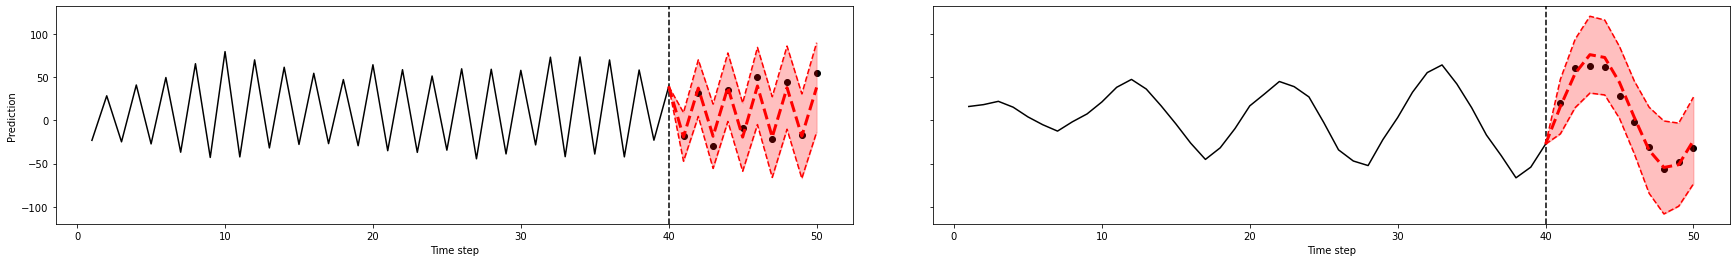

In [1142]:
plot_compare(test_datasets_varying_periodicity, all_coverages, all_intervals)


## Periodic component, small time-dependent noise profile, shorter time series

In [1143]:
from models.conformal import ConformalForecaster
from utils.make_data import generate_autoregressive_forecast_dataset, seasonal

# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 20
horizon = 10
noise_profile = None
periodicity = None
amplitude = 5
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

results_varying_periodicity_shorter = {}
models_varying_periodicity_shorter = []
test_datasets_varying_periodicity_shorter = []
for i in [2, 10]:
    periodicity = i
    noise_profile = [0.1 * k for k in range(seq_len + horizon)]
    train_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
    calibration_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    test_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    model_x = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)
    
    model_x.fit(train_dataset_x, calibration_dataset_x, epochs=epochs, lr=lr, batch_size=batch_size)
    
    coverages, intervals = model_x.evaluate_coverage(test_dataset_x)
    mean_coverage = torch.mean(coverages.float(), dim=0).item()
    interval_widths = (intervals[:, 1] - intervals[:, 0]).squeeze().mean(
        dim=0).tolist()

    result = {'coverages': coverages,
               'intervals': intervals,
               'mean_coverage': mean_coverage,
               'interval_widths': interval_widths}
    
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results_varying_periodicity_shorter['periodicity={}'.format(i)] = result
    
    models_varying_periodicity_shorter.append(model_x)
    test_datasets_varying_periodicity_shorter.append(test_dataset_x)

Epoch: 0	Train loss: 1513.7141845703125
Epoch: 50	Train loss: 380.0156677246094
Epoch: 100	Train loss: 241.64507141113282
Epoch: 150	Train loss: 202.02761993408203
Epoch: 200	Train loss: 188.87105255126954
Epoch: 250	Train loss: 180.60665740966797
Epoch: 300	Train loss: 168.5367004394531
Epoch: 350	Train loss: 160.74207000732423
Epoch: 400	Train loss: 155.99534301757814
Epoch: 450	Train loss: 148.8003128051758
Epoch: 500	Train loss: 142.6406021118164
Epoch: 550	Train loss: 137.4033348083496
Epoch: 600	Train loss: 133.45878677368165
Epoch: 650	Train loss: 129.83790283203126
Epoch: 700	Train loss: 128.92644500732422
Epoch: 750	Train loss: 126.80379714965821
Epoch: 800	Train loss: 122.19864501953126
Epoch: 850	Train loss: 125.23665924072266
Epoch: 900	Train loss: 117.54709701538086
Epoch: 950	Train loss: 129.88701400756835
Model 2:	coverage: 0.9559999704360962	widths: [51.1706428527832, 53.90670394897461, 63.8768196105957, 66.2872314453125, 73.71466827392578, 79.64240264892578, 86.1095657

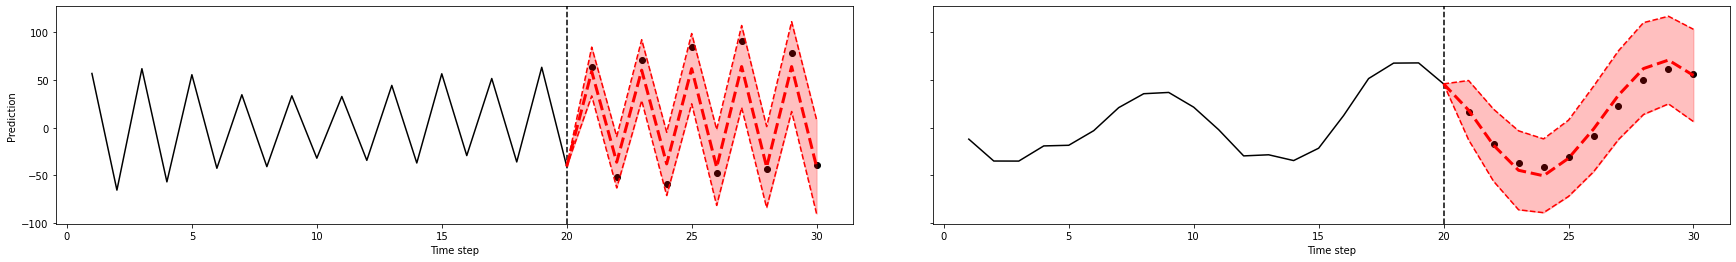

In [1144]:
all_coverages = [result['coverages'] for result in results_varying_periodicity_shorter.values()]
all_intervals = [result['intervals'] for result in results_varying_periodicity_shorter.values()]
plot_compare(test_datasets_varying_periodicity_shorter, all_coverages, all_intervals)

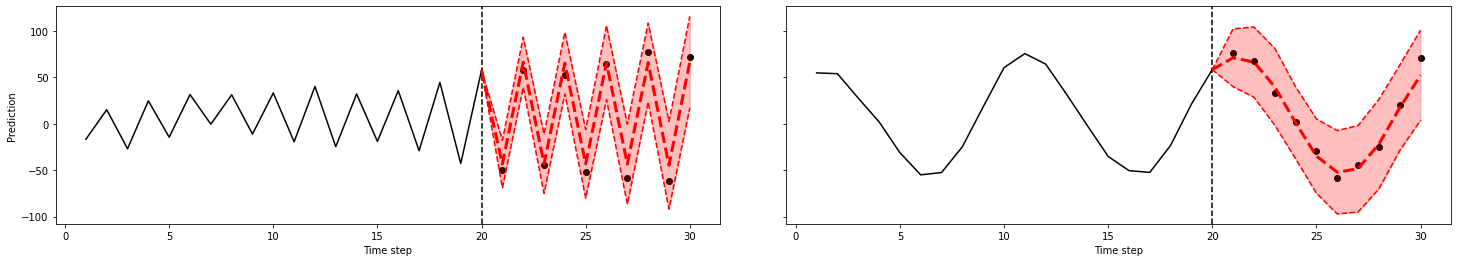

In [1151]:
plot_compare(test_datasets_varying_periodicity_shorter, all_coverages, all_intervals, figure_name='periodicity', figsize=(25,4))

## Periodicity and larger time-varying noise profile

In [1152]:
from models.conformal import ConformalForecaster
from utils.make_data import generate_autoregressive_forecast_dataset, seasonal

# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 20
horizon = 10
noise_profile = None
periodicity = None
amplitude = 5
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

results_varying_periodicity_shorter = {}
models_varying_periodicity_shorter = []
test_datasets_varying_periodicity_shorter = []
for i in [2, 10]:
    periodicity = i
    noise_profile = [0.5 * k for k in range(seq_len + horizon)]
    train_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
    calibration_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    test_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    model_x = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)
    
    model_x.fit(train_dataset_x, calibration_dataset_x, epochs=epochs, lr=lr, batch_size=batch_size)
    
    coverages, intervals = model_x.evaluate_coverage(test_dataset_x)
    mean_coverage = torch.mean(coverages.float(), dim=0).item()
    interval_widths = (intervals[:, 1] - intervals[:, 0]).squeeze().mean(
        dim=0).tolist()

    result = {'coverages': coverages,
               'intervals': intervals,
               'mean_coverage': mean_coverage,
               'interval_widths': interval_widths}
    
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results_varying_periodicity_shorter['periodicity={}'.format(i)] = result
    
    models_varying_periodicity_shorter.append(model_x)
    test_datasets_varying_periodicity_shorter.append(test_dataset_x)

Epoch: 0	Train loss: 1637.6876708984375
Epoch: 50	Train loss: 573.9538299560547
Epoch: 100	Train loss: 424.01050720214846
Epoch: 150	Train loss: 373.07933654785154
Epoch: 200	Train loss: 354.534765625
Epoch: 250	Train loss: 332.1649597167969
Epoch: 300	Train loss: 317.97275695800784
Epoch: 350	Train loss: 307.601301574707
Epoch: 400	Train loss: 301.9980712890625
Epoch: 450	Train loss: 309.94207763671875
Epoch: 500	Train loss: 303.5577423095703
Epoch: 550	Train loss: 295.77045288085935
Epoch: 600	Train loss: 314.0335632324219
Epoch: 650	Train loss: 291.12470092773435
Epoch: 700	Train loss: 282.2754272460937
Epoch: 750	Train loss: 286.14427490234374
Epoch: 800	Train loss: 488.56956481933594
Epoch: 850	Train loss: 336.14454956054686
Epoch: 900	Train loss: 325.31976928710935
Epoch: 950	Train loss: 318.36688842773435
Model 2:	coverage: 0.9139999747276306	widths: [77.55677032470703, 82.593505859375, 90.1058349609375, 89.24063873291016, 98.14818572998047, 99.07642364501953, 110.39588165283203

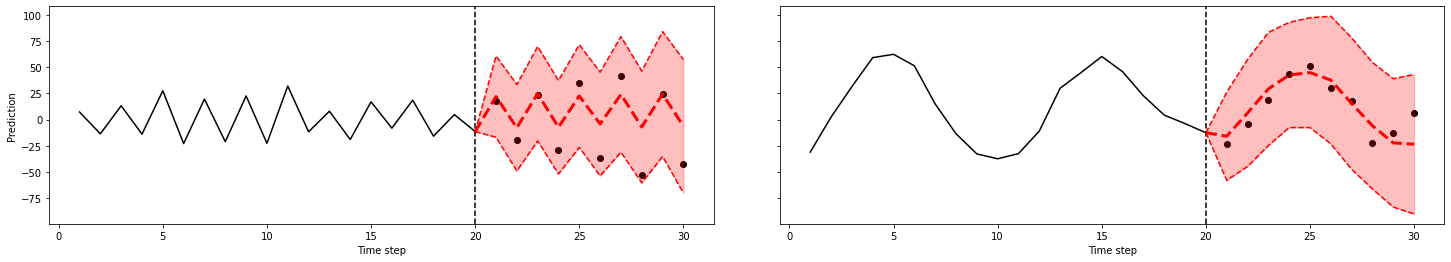

In [1154]:
all_coverages = [result['coverages'] for result in results_varying_periodicity_shorter.values()]
all_intervals = [result['intervals'] for result in results_varying_periodicity_shorter.values()]
plot_compare(test_datasets_varying_periodicity_shorter, all_coverages, all_intervals, figure_name='periodicity2', figsize=(25,4))

## Periodicity and larger static noise profile

In [8]:
%load_ext autoreload
%autoreload 2

## Time-dependent noise profile, no periodic component

In [17]:
from utils.data_processing_synthetic import get_synthetic_splits
get_synthetic_splits(noise_mode='time-dependent', cached=False)

[(<utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd93a009810>,
  <utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd937453410>),
 (<utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd93a0dbb90>,
  <utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd93a0db850>),
 (<utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd955f9ab90>,
  <utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd93a0e6b90>),
 (<utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd93a0db7d0>,
  <utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd93a0db550>),
 (<utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd93a0abe10>,
  <utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd93a0abb90>)]

In [9]:
from utils.train_synthetic import train_conformal_forecaster

In [18]:
results = train_conformal_forecaster(noise_mode='time-dependent', retrain=True)

Epoch: 0	Train loss: 66.24095649719239
Epoch: 50	Train loss: 10.29337100982666
Epoch: 100	Train loss: 9.632317066192627
Epoch: 150	Train loss: 8.949155902862548
Epoch: 200	Train loss: 7.9193109512329105
Epoch: 250	Train loss: 6.962215089797974
Epoch: 300	Train loss: 5.972176504135132
Epoch: 350	Train loss: 5.442095994949341
Epoch: 400	Train loss: 5.423411321640015
Epoch: 450	Train loss: 4.581943511962891
Epoch: 500	Train loss: 4.430440521240234
Epoch: 550	Train loss: 4.336389660835266
Epoch: 600	Train loss: 5.135818243026733
Epoch: 650	Train loss: 4.1494087219238285
Epoch: 700	Train loss: 3.9714523553848267
Epoch: 750	Train loss: 4.1846496105194095
Epoch: 800	Train loss: 3.8614495515823366
Epoch: 850	Train loss: 3.9767741918563844
Epoch: 900	Train loss: 3.841373872756958
Epoch: 950	Train loss: 3.786108899116516
Epoch: 0	Train loss: 75.80497436523437
Epoch: 50	Train loss: 15.42696933746338
Epoch: 100	Train loss: 14.33942232131958
Epoch: 150	Train loss: 12.711520576477051
Epoch: 200	Trai

In [5]:
results[0].keys()

dict_keys(['Point predictions', 'Errors', 'Independent coverage indicators', 'Joint coverage indicators', 'Upper limit', 'Lower limit', 'Mean independent coverage', 'Mean joint coverage', 'Confidence interval widths', 'Mean confidence interval widths'])

In [6]:
results = train_conformal_forecaster(noise_mode='static', retrain=True)

Epoch: 0	Train loss: 62.2966552734375
Epoch: 50	Train loss: 8.906346082687378
Epoch: 100	Train loss: 7.359507989883423
Epoch: 150	Train loss: 5.508194828033448
Epoch: 200	Train loss: 4.910768675804138
Epoch: 250	Train loss: 3.9676262378692626
Epoch: 300	Train loss: 4.6238635063171385
Epoch: 350	Train loss: 3.405360293388367
Epoch: 400	Train loss: 3.2466216325759887
Epoch: 450	Train loss: 3.2923015117645265
Epoch: 500	Train loss: 3.241017556190491
Epoch: 550	Train loss: 3.2432596921920775
Epoch: 600	Train loss: 4.550741171836853
Epoch: 650	Train loss: 3.755059909820557
Epoch: 700	Train loss: 2.845848822593689
Epoch: 750	Train loss: 2.9080684900283815
Epoch: 800	Train loss: 2.7287296295166015
Epoch: 850	Train loss: 3.1016319751739503
Epoch: 900	Train loss: 2.9410363912582396
Epoch: 950	Train loss: 2.5397347927093508
Epoch: 0	Train loss: 70.63137588500976
Epoch: 50	Train loss: 9.167267990112304
Epoch: 100	Train loss: 8.359336805343627
Epoch: 150	Train loss: 7.227769088745117
Epoch: 200	Tr

In [12]:
results = train_conformal_forecaster(noise_mode='periodic', retrain=True)

Epoch: 0	Train loss: 1569.3938598632812
Epoch: 50	Train loss: 377.86641082763674
Epoch: 100	Train loss: 225.07015533447264
Epoch: 150	Train loss: 181.85390930175782
Epoch: 200	Train loss: 156.69668426513672
Epoch: 250	Train loss: 144.86473541259767
Epoch: 300	Train loss: 139.84007720947267
Epoch: 350	Train loss: 132.21636886596679
Epoch: 400	Train loss: 123.63358459472656
Epoch: 450	Train loss: 121.51000289916992
Epoch: 500	Train loss: 122.53247146606445
Epoch: 550	Train loss: 114.98192291259765
Epoch: 600	Train loss: 138.40487060546874
Epoch: 650	Train loss: 112.13117294311523
Epoch: 700	Train loss: 113.25227813720703
Epoch: 750	Train loss: 107.98965988159179
Epoch: 800	Train loss: 113.03084106445313
Epoch: 850	Train loss: 108.27653427124024
Epoch: 900	Train loss: 106.10040664672852
Epoch: 950	Train loss: 102.87810134887695
Epoch: 0	Train loss: 1433.3804443359375
Epoch: 50	Train loss: 351.48277282714844
Epoch: 100	Train loss: 232.59820098876952
Epoch: 150	Train loss: 203.6706222534179

In [1]:
from utils.train_synthetic import train_blockwise_forecaster
results = train_blockwise_forecaster(noise_mode='time-dependent', retrain=True)

Epoch:  0 | train loss: 56.1769


ValueError: only one element tensors can be converted to Python scalars